In [1]:
"""
data loader
"""

from mxnet import gluon
from mxnet import image
from mxnet import nd

batch_size =  32
data_shape = 256

rec_prefix = "../dataset/sdl-coins/rec/sdl_"
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape = (3, data_shape, data_shape),
        path_imgrec=rec_prefix+'train.rec',
        path_imgidx=rec_prefix+'train.idx',
        shuffle=True,
        mean=True,  
        rand_crop=1,  # data argument
        min_object_covered=0.95,
        max_attempts=200)
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape), 
        path_imgrec=rec_prefix+'val.rec',
        shuffle=False,
        mean=True)
    
    return train_iter, valid_iter, class_names, num_class

train_data, valid_data, class_names, num_class = get_iterators(data_shape, batch_size)


In [2]:
num = 0
for i, batch in enumerate(train_data):
    num += batch.data[0].shape[0]
print num
train_data.reset()

num = 0
for i, batch in enumerate(valid_data):
    num += batch.data[0].shape[0]
print num
valid_data.reset()

96
32


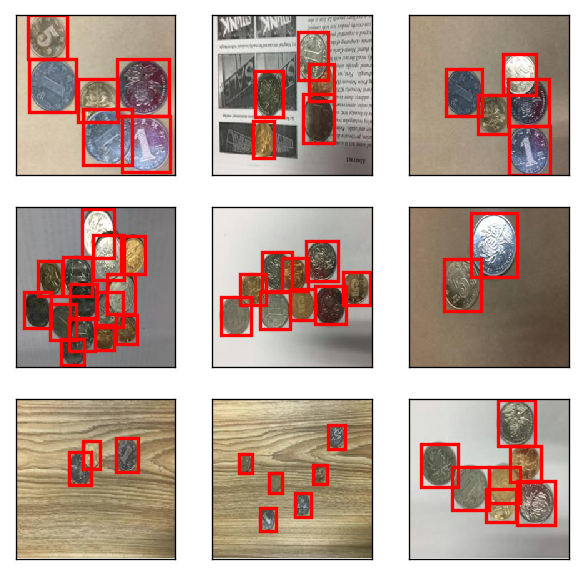

In [3]:
"""
data plot
"""
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

rgb_mean = nd.array([123, 117, 104])

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                  fill=False, edgecolor=color, linewidth=linewidth)

def plot_images(images, labels):
    images = images.transpose((0, 2, 3, 1)) + rgb_mean
    images = images.asnumpy()
    _, figs = plt.subplots(3, 3, figsize=(6, 6))
    for i in range(3):
        for j in range(3):
            image = (images[3 * i + j] / 255).clip(0, 1)
            figs[i][j].imshow(image)
            
            label = labels[3 * i + j]
            for l in label:
                rect = box_to_rect(l[1:5] * images.shape[2], 'red', 2)
                figs[i][j].add_patch(rect)
            
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()
    
batch = train_data.next()
images = batch.data[0][:9]
labels = batch.label[0][:9]
plot_images(images, labels)

In [4]:
"""
model define
"""
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior

def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

def flatten_prediction(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

class ToySSD(gluon.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = len(sizes_list[0]) + len(ratios_list[0]) - 1
        self.verbose = verbose
        
        # part 1
        self.body = nn.HybridSequential() 
        for filters in [16, 32, 64]:
            self.body.add(down_sample(filters))
        
        # part 2
        self.downsamples = nn.HybridSequential()
        for _ in range(3):
            self.downsamples.add(down_sample(128))
            
        # part 3
        self.class_predictors = nn.HybridSequential()
        self.box_predictors = nn.HybridSequential()
        for _ in range(5):
            self.class_predictors.add(class_predictor(num_class, num_anchors))
            self.box_predictors.add(box_predictor(num_anchors))
        
    def hybrid_forward(self, F, x):
        anchors, class_preds, box_preds = [], [], []
        
        x = self.body(x)
        for i in range(5):
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))
            class_preds.append(flatten_prediction(self.class_predictors[i](x)))
            box_preds.append(flatten_prediction(self.box_predictors[i](x)))
            
            if self.verbose:
                print "Predict scale", i, x.shape, 'with', anchors[-1].shape[1], 'anchors'
            
            if i < 3:
                x = self.downsamples[i](x)
            elif i == 3:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
            
        anchors = concat_predictions(anchors)
        class_preds = concat_predictions(class_preds).reshape(shape=(0, -1, self.num_class + 1))
        box_preds = concat_predictions(box_preds)
        return anchors, box_preds, class_preds
        

In [5]:
# get class label and box offset(anchor box and batch label) from anchors, batch label
from mxnet.contrib.ndarray import MultiBoxTarget
"""
find class label and offset label for every anchor box
"""
def training_targets(anchors, labels, class_preds):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5
net = ToySSD(2, sizes_list, ratios_list, verbose=True)

# net.hybridize()  # cannot use cuase MultiBoxPrior not support symbol
net.initialize()
anchors, box_preds, class_preds = net(batch.data[0])
print anchors.shape, class_preds.shape, box_preds.shape

box_offset, box_mask, class_label = training_targets(anchors, batch.label[0], class_preds)
print box_offset.shape, box_mask.shape, class_label.shape

for i in range(len(box_mask[0])):
    if box_mask[0][i] > 1e-5:
        print i
        break
print box_offset[0][i: i+16]
print box_mask[0][i:i+16]
print class_label[0][i//4:(i+16)//4]

Predict scale 0 (32L, 64L, 32L, 32L) with 4096 anchors
Predict scale 1 (32L, 128L, 16L, 16L) with 1024 anchors
Predict scale 2 (32L, 128L, 8L, 8L) with 256 anchors
Predict scale 3 (32L, 128L, 4L, 4L) with 64 anchors
Predict scale 4 (32L, 128L, 1L, 1L) with 4 anchors
(1L, 5444L, 4L) (32L, 5444L, 3L) (32L, 21776L)
(32L, 21776L) (32L, 21776L) (32L, 5444L)
1108

[ 0.9305594   2.19599533 -0.50379932  0.06777633  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.        ]
<NDArray 16 @cpu(0)>

[ 1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<NDArray 16 @cpu(0)>

[ 2.  0.  0.  0.]
<NDArray 4 @cpu(0)>


In [6]:
"""
loss define
"""

class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gama=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self.alpha = alpha
        self.gama = gama
        self.axis = axis
        self.batch_axis = batch_axis
    
    def hybrid_forward(self, F, y, label):
        y = F.softmax(y)
        pj = y.pick(label, axis=self.axis, keepdims=True)
        loss = - (self.alpha * ((1-pj) ** self.gama)) * pj.log()
        return loss.mean(axis=self.batch_axis, exclude=True)

    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label, mask):
        loss = F.smooth_l1((y - label) * mask, scalar=1.0)
        return loss.mean(self.batch_axis, exclude=True)
    
cls_loss = FocalLoss()
box_loss = SmoothL1Loss()


In [19]:
"""
train net
"""
import mxnet as mx
from mxnet import autograd
from mxnet import metric
import time
ctx = mx.gpu(0)
#ctx = mx.cpu()

def train(net, start_epoch, end_epoch, trainer=None, lr=0.3):
    if trainer is None:
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': 5e-4})
    cls_metric = metric.Accuracy()
    box_metric = metric.MAE()
    
    for e in range(start_epoch, end_epoch):
        C = 0
        R = 0
        _loss = 0
        train_data.reset()
        cls_metric.reset()
        box_metric.reset()
        tic = time.time()
        for i, batch in enumerate(train_data):
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            with autograd.record():
                anchors, box_preds, cls_preds = net(data)
                box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)))
                loss1 = cls_loss(cls_preds, cls_labels)
                loss2 = box_loss(box_preds, box_offset, box_mask)
                loss = loss1 + loss2
                _loss += nd.mean(loss).asscalar()
            
            loss.backward()
            trainer.step(data.shape[0])
            
            cls_metric.update([cls_labels], [cls_preds.transpose((0, 2, 1))])
            box_metric.update([box_offset], [box_preds * box_mask])
            
            box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)),
                                                              overlap_threshold=0.75, negative_mining_ratio=3.0)
            C += cls_labels.shape[0] * cls_labels.shape[1] - nd.sum(cls_labels == -1)
            R += nd.sum(cls_labels == cls_preds.argmax(axis=2))

        
        print "epoch", e, cls_metric.get(), box_metric.get(), (R/C).asscalar(), _loss
        #print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (epoch, *(cls_metric.get()), *(box_metric.get()), time.time()-tic))


sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5

# net.hybridize()  # cannot use cuase MultiBoxPrior not support symbol

# train_data.reshape(label_shape=(3, 5))
# valid_data = valid_data.sync_label_shape(train_data)


In [21]:
net = ToySSD(2, sizes_list, ratios_list, verbose=False, prefix="ssd_")
net.initialize(ctx=ctx)
train(net, 0, 50, lr=0.5)

epoch 0 ('accuracy', 0.7611896889542004) ('mae', 0.027733481178681057) 0.0367162 0.374229207635
epoch 1 ('accuracy', 0.963463216385011) ('mae', 0.022239010160168011) 0.0012 0.118422063068
epoch 2 ('accuracy', 0.971998989713446) ('mae', 0.018815719832976658) 0.0285596 0.0832413826138
epoch 3 ('accuracy', 0.973426402155278) ('mae', 0.01951244908074538) 0.091853 0.0774750504643
epoch 4 ('accuracy', 0.9763539370560862) ('mae', 0.018735838433106739) 0.137889 0.0717181861401
epoch 5 ('accuracy', 0.9785409778349253) ('mae', 0.01766618900001049) 0.214344 0.0633264351636
epoch 6 ('accuracy', 0.977877020573108) ('mae', 0.018535553167263668) 0.262673 0.0631425026804
epoch 7 ('accuracy', 0.9779114621601763) ('mae', 0.018314956997831661) 0.262563 0.0614934470505
epoch 8 ('accuracy', 0.9791264848150869) ('mae', 0.017634757173558075) 0.343248 0.0588298067451
epoch 9 ('accuracy', 0.9791991948322312) ('mae', 0.01757782232016325) 0.363047 0.0560076646507
epoch 10 ('accuracy', 0.9799913513348029) ('mae',

In [22]:
train(net, 50, 100, lr=0.05)

epoch 50 ('accuracy', 0.9824080026940974) ('mae', 0.014789819406966368) 0.453328 0.0398139758036
epoch 51 ('accuracy', 0.9826127387950037) ('mae', 0.015190674612919489) 0.488598 0.0411041136831
epoch 52 ('accuracy', 0.9832786094783248) ('mae', 0.014348779805004597) 0.491294 0.0383717371151
epoch 53 ('accuracy', 0.9829035788635807) ('mae', 0.014956460644801458) 0.462712 0.0400574924424
epoch 54 ('accuracy', 0.9822740631888317) ('mae', 0.015195354508856932) 0.502782 0.0403031911701
epoch 55 ('accuracy', 0.9819755694342396) ('mae', 0.015394743842383226) 0.492089 0.0413873568177
epoch 56 ('accuracy', 0.9826108253734999) ('mae', 0.01507378276437521) 0.487795 0.0405925195664
epoch 57 ('accuracy', 0.9825840374724467) ('mae', 0.014790488717456659) 0.488156 0.0396865075454
epoch 58 ('accuracy', 0.982318071883419) ('mae', 0.015285459967950979) 0.510961 0.0407438352704
epoch 59 ('accuracy', 0.9824443577026696) ('mae', 0.014517435804009438) 0.49625 0.0390778305009
epoch 60 ('accuracy', 0.983159977

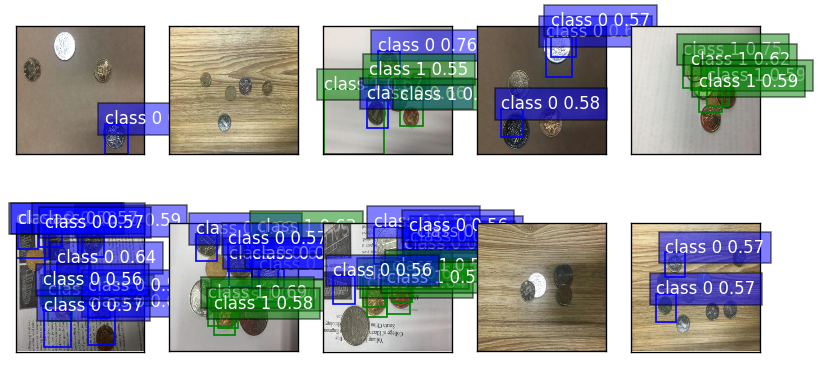

In [26]:
from mxnet.contrib.ndarray import MultiBoxDetection
from utils.utils import show_det_results
mpl.rcParams['figure.figsize'] = (6,6)
valid_data.reset()
batch = valid_data.next()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=True, nms_threshold=0.45)

imgs = data.transpose((0, 2, 3, 1)).asnumpy() + rgb_mean.asnumpy()
show_det_results(imgs[:10], outs=out[:10], threshold=0.55)

In [15]:
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)))

In [18]:
print nd.sum(cls_labels > 0), nd.mean(cls_labels > 0)


[ 674.]
<NDArray 1 @gpu(0)> 
[ 0.00386894]
<NDArray 1 @gpu(0)>
